# Test 

In [1]:
import pandas as pd

df_test = pd.read_parquet("data/test.parquet")

In [2]:
# Compter le nombre de sessions par utilisateur
sessions_par_user = df_test.groupby('userId')['sessionId'].nunique().reset_index()
sessions_par_user.columns = ['userId', 'nombre_sessions']

# Trier par nombre de sessions décroissant et prendre les 5 premiers
top_5_users = sessions_par_user.sort_values('nombre_sessions', ascending=False).head(5)

print(top_5_users)

       userId  nombre_sessions
739   1261737           134438
307   1116029              112
2848  1979129               99
1899  1663631               97
2009  1703411               96


In [3]:
# 1. Compter le nombre de logs par session
logs_par_session = df_test.groupby('sessionId').size().reset_index(name='nombre_logs')

# 2. Les 5 sessions avec le plus de logs
top_5_sessions = logs_par_session.sort_values('nombre_logs', ascending=False).head(5)
print("Top 5 sessions avec le plus de logs :")
print(top_5_sessions)

# 3. Nombre moyen de logs par session
moyenne_logs = logs_par_session['nombre_logs'].mean()
print(f"\nNombre moyen de logs par session : {moyenne_logs:.2f}")

# Statistiques supplémentaires utiles
print(f"Nombre total de sessions : {len(logs_par_session)}")
print(f"Médiane de logs par session : {logs_par_session['nombre_logs'].median()}")
print(f"Écart-type : {logs_par_session['nombre_logs'].std():.2f}")

Top 5 sessions avec le plus de logs :
        sessionId  nombre_logs
97687      128347         1371
108363     143782         1315
135942     185100         1221
53426       64879         1102
128331     173319         1083

Nombre moyen de logs par session : 30.12
Nombre total de sessions : 145863
Médiane de logs par session : 5.0
Écart-type : 70.93


### Function

In [4]:
data_clean = df_test[df_test['userId'] != '1261737']


In [5]:
"""
Fonction FINALE par SESSION avec 19 features optimisées
Calcul à chaque nouvelle session (au lieu de fenêtre fixe)
ULTRA-OPTIMISÉE pour < 2 minutes
"""

import pandas as pd
import numpy as np
from datetime import timedelta
import gc


def create_features_per_session(
    df: pd.DataFrame,
    batch_size: int = 10000,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Calcule 19 features à chaque nouvelle session de chaque user
    
    Colonnes requises: userId, sessionId, time, page, registration, level, userAgent
    
    Returns:
        DataFrame avec (userId, sessionId, session_time, 19 features)
    """
    
    if verbose:
        print("="*80)
        print("CALCUL DES 19 FEATURES PAR SESSION")
        print("="*80)
        print()
    
    # ========================================================================
    # PRÉPARATION
    # ========================================================================
    
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df['date'] = df['time'].dt.date
    df['registration'] = pd.to_datetime(df['registration'])
    df = df.sort_values(['userId', 'sessionId', 'time']).reset_index(drop=True)
    
    if verbose:
        print("Création des flags...")
    
    # Flags (vectorisé)
    df['is_nextsong'] = (df['page'] == 'NextSong').astype(np.int8)
    df['is_thumbs_up'] = (df['page'] == 'Thumbs Up').astype(np.int8)
    df['is_thumbs_down'] = (df['page'] == 'Thumbs Down').astype(np.int8)
    df['is_error'] = (df['page'] == 'Error').astype(np.int8)
    df['is_help'] = (df['page'] == 'Help').astype(np.int8)
    df['is_settings'] = (df['page'] == 'Settings').astype(np.int8)
    df['is_downgrade'] = (df['page'] == 'Downgrade').astype(np.int8)
    
    # Device type
    def parse_ua(ua):
        if pd.isna(ua):
            return 'unknown'
        ua_str = str(ua)
        if 'iPhone' in ua_str or 'iPad' in ua_str or 'Android' in ua_str:
            return 'mobile'
        return 'desktop'
    
    df['device_type'] = df['userAgent'].apply(parse_ua)
    df['is_mobile_action'] = (df['device_type'] == 'mobile').astype(np.int8)
    
    if verbose:
        print(f"Dataset: {df.shape}")
        print(f"Users: {df['userId'].nunique()}")
        print(f"Sessions: {df['sessionId'].nunique()}")
        print()
    
    # ========================================================================
    # IDENTIFIER LES SESSIONS
    # ========================================================================
    
    if verbose:
        print("Identification des sessions...")
    
    # Première ligne de chaque session = point de prédiction
    session_starts = df.groupby(['userId', 'sessionId']).agg({
        'time': 'min',
        'registration': 'first'
    }).reset_index()
    session_starts.columns = ['userId', 'sessionId', 'session_time', 'registration']
    
    total_sessions = len(session_starts)
    num_batches = (total_sessions + batch_size - 1) // batch_size
    
    if verbose:
        print(f"Total sessions: {total_sessions:,}")
        print(f"Batch size: {batch_size:,}")
        print(f"Nombre de batches: {num_batches}")
        print()
    
    # ========================================================================
    # PRÉ-CALCUL : GROUPBY PAR USER (OPTIMISATION MAJEURE)
    # ========================================================================
    
    if verbose:
        print("Pré-calcul des groupes par user...")
    
    user_groups = {user_id: group for user_id, group in df.groupby('userId', sort=False)}
    
    # ========================================================================
    # TRAITEMENT PAR BATCH DE SESSIONS
    # ========================================================================
    
    all_features = []
    
    for batch_idx in range(num_batches):
        if verbose:
            print(f"Batch {batch_idx + 1}/{num_batches}...", end=' ')
        
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, total_sessions)
        batch_sessions = session_starts.iloc[start_idx:end_idx]
        
        batch_features = []
        
        for idx, row in batch_sessions.iterrows():
            user_id = row['userId']
            session_id = row['sessionId']
            session_time = row['session_time']
            registration = row['registration']
            
            # Données user (déjà filtrées)
            user_data = user_groups[user_id]
            
            # Filtrer AVANT cette session
            user_data_before = user_data[user_data['time'] < session_time]
            
            if len(user_data_before) == 0:
                # Première session : features par défaut
                features = {
                    'userId': user_id,
                    'sessionId': session_id,
                    'session_time': session_time,
                    'negative_actions_last7d_vs_avg': 1.0,
                    'consistency_score': 0.0,
                    'consecutive_days_inactive': 0,
                    'session_frequency_change': 1.0,
                    'sessions_last7d_vs_avg': 1.0,
                    'thumbs_down_last_14days': 0,
                    'days_without_thumbs_up': (session_time - registration).days,
                    'has_downgrade_last_15days': 0,
                    'activity_trend_last_14days': 1.0,
                    'songs_listened_last_14days': 0,
                    'help_visits_14d': 0,
                    'error_rate_14d': 0.0,
                    'settings_visits_14d': 0,
                    'frustration_score': 0.0,
                    'is_paid': 0,
                    'has_downgraded': 0,
                    'mobile_usage_ratio_14d': 0.5,
                    'days_since_registration': (session_time - registration).days,
                    'has_ever_paid': 0
                }
                batch_features.append(features)
                continue
            
            # Fenêtres temporelles
            window_14d_start = session_time - timedelta(days=14)
            window_7d_start = session_time - timedelta(days=7)
            window_15d_start = session_time - timedelta(days=15)
            
            data_14d = user_data_before[(user_data_before['time'] >= window_14d_start)]
            data_7d = user_data_before[(user_data_before['time'] >= window_7d_start)]
            data_week2 = user_data_before[(user_data_before['time'] >= window_14d_start) & 
                                          (user_data_before['time'] < window_7d_start)]
            data_15d = user_data_before[(user_data_before['time'] >= window_15d_start)]
            data_lifetime = user_data_before
            
            first_activity = data_lifetime['time'].min()
            lifetime_days = (session_time - first_activity).days + 1
            
            # ============================================================
            # CALCUL DES 19 FEATURES
            # ============================================================
            
            # 1. negative_actions_last7d_vs_avg
            thumbs_down_7d = data_7d['is_thumbs_down'].sum()
            negative_7d = thumbs_down_7d + data_7d['is_error'].sum() + data_7d['is_help'].sum() + data_7d['is_settings'].sum()
            negative_lifetime = (data_lifetime['is_thumbs_down'].sum() + 
                                data_lifetime['is_error'].sum() + 
                                data_lifetime['is_help'].sum() + 
                                data_lifetime['is_settings'].sum())
            actions_7d = len(data_7d)
            actions_lifetime = len(data_lifetime)
            negative_7d_norm = negative_7d / max(actions_7d, 1)
            negative_lifetime_norm = negative_lifetime / max(actions_lifetime, 1)
            negative_actions_last7d_vs_avg = negative_7d_norm / max(negative_lifetime_norm, 0.001)
            
            # 2. consistency_score
            window_end = session_time - timedelta(days=1)
            date_range = pd.date_range(start=window_14d_start.date(), end=window_end.date(), freq='D')
            daily_sessions = data_14d.groupby('date')['sessionId'].nunique()
            daily_sessions_full = pd.Series(0, index=date_range)
            daily_sessions_full.update(daily_sessions)
            mean_sessions = daily_sessions_full.mean()
            std_sessions = daily_sessions_full.std()
            consistency_score = std_sessions / mean_sessions if mean_sessions > 0 else 0.0
            
            # 3. consecutive_days_inactive
            active_dates = set(data_14d['date'].unique())
            max_consecutive_inactive = 0
            current_streak = 0
            for date in date_range:
                if date.date() not in active_dates:
                    current_streak += 1
                    max_consecutive_inactive = max(max_consecutive_inactive, current_streak)
                else:
                    current_streak = 0
            consecutive_days_inactive = max_consecutive_inactive
            
            # 4. session_frequency_change
            sessions_week1 = data_7d['sessionId'].nunique()
            sessions_week2 = data_week2['sessionId'].nunique()
            session_frequency_change = sessions_week1 / max(sessions_week2, 1)
            
            # 5. sessions_last7d_vs_avg
            sessions_7d = data_7d['sessionId'].nunique()
            sessions_lifetime = data_lifetime['sessionId'].nunique()
            sessions_lifetime_avg = sessions_lifetime / max(lifetime_days, 1)
            sessions_7d_avg = sessions_7d / 7
            sessions_last7d_vs_avg = sessions_7d_avg / max(sessions_lifetime_avg, 0.01)
            
            # 6. thumbs_down_last_14days
            thumbs_down_last_14days = data_14d['is_thumbs_down'].sum()
            
            # 7. days_without_thumbs_up
            thumbs_up_data = data_lifetime[data_lifetime['is_thumbs_up'] == 1]
            if len(thumbs_up_data) > 0:
                last_thumbs_up = thumbs_up_data['time'].max()
                days_without_thumbs_up = (session_time - last_thumbs_up).days
            else:
                days_without_thumbs_up = (session_time - registration).days
            
            # 8. has_downgrade_last_15days
            has_downgrade_last_15days = int(data_15d['is_downgrade'].sum() > 0)
            
            # 9. activity_trend_last_14days
            songs_week1 = data_7d['is_nextsong'].sum()
            songs_week2 = data_week2['is_nextsong'].sum()
            activity_trend_last_14days = songs_week1 / max(songs_week2, 1)
            
            # 10. songs_listened_last_14days
            songs_listened_last_14days = data_14d['is_nextsong'].sum()
            
            # 11. help_visits_14d
            help_visits_14d = data_14d['is_help'].sum()
            
            # 12. error_rate_14d
            errors_14d = data_14d['is_error'].sum()
            total_actions_14d = len(data_14d)
            error_rate_14d = errors_14d / max(total_actions_14d, 1)
            
            # 13. settings_visits_14d
            settings_visits_14d = data_14d['is_settings'].sum()
            
            # 14. frustration_score
            frustration_score = (
                thumbs_down_last_14days * 2.0 +
                help_visits_14d * 1.5 +
                settings_visits_14d * 1.5 +
                has_downgrade_last_15days * 3.0
            )
            
            # 15. is_paid
            current_level = data_lifetime.iloc[-1]['level'] if len(data_lifetime) > 0 else 'free'
            is_paid = 1 if current_level == 'paid' else 0
            
            # 16. has_downgraded
            levels = data_lifetime.sort_values('time')['level'].tolist()
            has_downgraded = 0
            for i in range(len(levels) - 1):
                if levels[i] == 'paid' and levels[i+1] == 'free':
                    has_downgraded = 1
                    break
            
            # 17. mobile_usage_ratio_14d
            mobile_actions_14d = data_14d['is_mobile_action'].sum()
            mobile_usage_ratio_14d = mobile_actions_14d / max(total_actions_14d, 1)
            
            # 18. days_since_registration
            days_since_registration = (session_time - registration).days
            
            # 19. has_ever_paid
            has_ever_paid = 1 if 'paid' in levels else 0
            
            # ============================================================
            # ASSEMBLER
            # ============================================================
            
            features = {
                'userId': user_id,
                'sessionId': session_id,
                'session_time': session_time,
                'negative_actions_last7d_vs_avg': negative_actions_last7d_vs_avg,
                'consistency_score': consistency_score,
                'consecutive_days_inactive': consecutive_days_inactive,
                'session_frequency_change': session_frequency_change,
                'sessions_last7d_vs_avg': sessions_last7d_vs_avg,
                'thumbs_down_last_14days': int(thumbs_down_last_14days),
                'days_without_thumbs_up': days_without_thumbs_up,
                'has_downgrade_last_15days': has_downgrade_last_15days,
                'activity_trend_last_14days': activity_trend_last_14days,
                'songs_listened_last_14days': int(songs_listened_last_14days),
                'help_visits_14d': int(help_visits_14d),
                'error_rate_14d': error_rate_14d,
                'settings_visits_14d': int(settings_visits_14d),
                'frustration_score': frustration_score,
                'is_paid': is_paid,
                'has_downgraded': has_downgraded,
                'mobile_usage_ratio_14d': mobile_usage_ratio_14d,
                'days_since_registration': days_since_registration,
                'has_ever_paid': has_ever_paid
            }
            
            batch_features.append(features)
        
        # Convertir batch
        if batch_features:
            batch_df = pd.DataFrame(batch_features)
            all_features.append(batch_df)
        
        if verbose:
            print(f"✓ ({len(batch_features)} sessions)")
        
        del batch_features
        gc.collect()
    
    # ========================================================================
    # COMBINER
    # ========================================================================
    
    if verbose:
        print()
        print("Combinaison finale...")
    
    final_df = pd.concat(all_features, ignore_index=True)
    
    if verbose:
        print()
        print("="*80)
        print("✅ 19 FEATURES PAR SESSION CRÉÉES")
        print("="*80)
        print(f"Shape: {final_df.shape}")
        print(f"Sessions par user (moyenne): {len(final_df) / final_df['userId'].nunique():.1f}")
        print()
        print(final_df.head())
    
    return final_df

In [6]:
df_test_features = create_features_per_session(data_clean)

CALCUL DES 19 FEATURES PAR SESSION

Création des flags...
Dataset: (3739498, 29)
Users: 2903
Sessions: 41384

Identification des sessions...
Total sessions: 43,608
Batch size: 10,000
Nombre de batches: 5

Pré-calcul des groupes par user...
Batch 1/5... ✓ (10000 sessions)
Batch 2/5... ✓ (10000 sessions)
Batch 3/5... ✓ (10000 sessions)
Batch 4/5... ✓ (10000 sessions)
Batch 5/5... ✓ (3608 sessions)

Combinaison finale...

✅ 19 FEATURES PAR SESSION CRÉÉES
Shape: (43608, 22)
Sessions par user (moyenne): 15.0

    userId  sessionId        session_time  negative_actions_last7d_vs_avg  \
0  1000655      19711 2018-10-03 09:00:59                             1.0   
1  1000655      36911 2018-10-05 22:06:38                             1.0   
2  1000655      49298 2018-10-07 19:32:55                             1.0   
3  1000655      54275 2018-10-18 04:38:45                             0.0   
4  1000655      96058 2018-10-21 14:25:04                             0.0   

   consistency_score  conse

### Predict

In [7]:
def predict_churn(model, df_test_features, best_threshold=0.5):
    """
    Predict churn on test data using trained model with custom threshold.
    
    Parameters:
    -----------
    model : trained classifier (RandomForest, XGBoost, etc.)
        Model from training function
    df_test_features : pd.DataFrame
        Output from create_features_test()
    best_threshold : float, default=0.5
        Optimal threshold for classification (from threshold optimization)
    
    Returns:
    --------
    pd.DataFrame with predictions and probabilities
    """
    # Prepare features (same as training)
    feature_cols = [col for col in df_test_features.columns 
                    if col not in ['userId', 'prediction_date', 'session_time','session_id','prediction_date', 'session_start', 'registration']]
    X_test = df_test_features[feature_cols].fillna(0)
    
    print(f"Predicting on {len(X_test):,} sessions...")
    print(f"Using threshold: {best_threshold:.3f}")
    
    # Get probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Apply custom threshold
    y_pred = (y_pred_proba >= best_threshold).astype(int)
    
    # Create results dataframe
    results = df_test_features[['userId']].copy()
    results['churn_probability'] = y_pred_proba
    results['predicted_churn'] = y_pred
    
    # Statistics
    print(f"\n{'='*50}")
    print(f"PREDICTIONS (threshold = {best_threshold:.3f})")
    print(f"{'='*50}")
    print(f"  Will churn (1): {(y_pred == 1).sum():,} ({(y_pred == 1).sum()/len(y_pred)*100:.1f}%)")
    print(f"  No churn (0):   {(y_pred == 0).sum():,} ({(y_pred == 0).sum()/len(y_pred)*100:.1f}%)")
    print(f"\nProbability Statistics:")
    print(f"  Average: {y_pred_proba.mean():.3f}")
    print(f"  Median:  {np.median(y_pred_proba):.3f}")
    print(f"  Min:     {y_pred_proba.min():.3f}")
    print(f"  Max:     {y_pred_proba.max():.3f}")
    print(f"\nRisk Segments:")
    print(f"{'='*50}\n")
    
    return results

In [8]:
# Meilleur threshold basé sur les résultats du test: 0.55
best_threshold = 0.55

In [9]:
df_test_features.columns

Index(['userId', 'sessionId', 'session_time', 'negative_actions_last7d_vs_avg',
       'consistency_score', 'consecutive_days_inactive',
       'session_frequency_change', 'sessions_last7d_vs_avg',
       'thumbs_down_last_14days', 'days_without_thumbs_up',
       'has_downgrade_last_15days', 'activity_trend_last_14days',
       'songs_listened_last_14days', 'help_visits_14d', 'error_rate_14d',
       'settings_visits_14d', 'frustration_score', 'is_paid', 'has_downgraded',
       'mobile_usage_ratio_14d', 'days_since_registration', 'has_ever_paid'],
      dtype='object')

In [10]:
# 3. Predict
submission = predict_churn(production_model, df_test_features, best_threshold=0.51)

NameError: name 'production_model' is not defined

In [ ]:
# Créer une ligne pour user 1261737
new_row = pd.DataFrame({
    'userId': ['1261737'],
    'predicted_churn': [0]
})

# Ajouter à ton submission
submission_complete = pd.concat([submission, new_row], ignore_index=True)

print(f"Submission before: {len(submission)} rows")
print(f"Submission after: {len(submission_complete)} rows")

# Vérifier
print(f"\nUser 1261737 in submission: {'1261737' in submission_complete['userId'].values}")

Submission before: 43608 rows
Submission after: 43609 rows

User 1261737 in submission: True


In [ ]:
# Renommer les colonnes pour Kaggle
submission_final = submission_complete.rename(columns={
    'userId': 'id',
    'predicted_churn': 'target'
})

# Vérifier
print("Submission structure:")
print(submission_final.head())
print(f"\nColumns: {submission_final.columns.tolist()}")
print(f"Shape: {submission_final.shape}")

# Vérifier pas de null
print(f"\nNull values: {submission_final.isnull().sum()}")

print("\n✓ Submission ready with columns: id, target")

Submission structure:
        id  churn_probability  target
0  1000655           0.102903       0
1  1000655           0.158946       0
2  1000655           0.133645       0
3  1000655           0.207966       0
4  1000655           0.184813       0

Columns: ['id', 'churn_probability', 'target']
Shape: (43609, 3)

Null values: id                   0
churn_probability    1
target               0
dtype: int64

✓ Submission ready with columns: id, target


In [ ]:
# Grouper par userId : 1 si au moins un 1, sinon 0
submission_final = submission_final.groupby('id').agg({
    'target': 'max'  # max = 1 si au moins un 1, sinon 0
}).reset_index()

print(f"After deduplication: {len(submission_final)} unique users")
print(f"\nTarget distribution:")
print(submission_final['target'].value_counts())

# Vérifier plus de duplicates
print(f"\nDuplicates: {submission_final['id'].duplicated().sum()}")


After deduplication: 2904 unique users

Target distribution:
target
1    2268
0     636
Name: count, dtype: int64

Duplicates: 0


In [ ]:
# 1. Identifier les userId manquants
expected_users = df_test['userId'].unique()
submitted_users = submission_final['id'].unique()

print(f"Expected users: {len(expected_users)}")
print(f"Submitted users: {len(submitted_users)}")

# Trouver les manquants
missing_users = set(expected_users) - set(submitted_users)
print(f"\nMissing users: {len(missing_users)}")
print(f"Missing user IDs: {list(missing_users)[:10]}")  # Afficher les 10 premiers

# 2. Créer des lignes pour les utilisateurs manquants (avec target=0)
missing_rows = pd.DataFrame({
    'id': list(missing_users),
    'target': 0
})

# 3. Ajouter à la submission
submission_complete = pd.concat([submission_final, missing_rows], ignore_index=True)

print(f"\nBefore adding missing: {len(submission_final)} rows")
print(f"After adding missing: {len(submission_complete)} rows")

# 4. Vérifier qu'on a bien 2904
assert len(submission_complete) == 2904, f"Expected 2904, got {len(submission_complete)}"

# 5. Trier par id (optionnel mais propre)
submission_complete = submission_complete.sort_values('id').reset_index(drop=True)

# 6. Sauvegarder
submission_complete.to_csv('submission.csv', index=False)
print("\n✓ Complete submission with all 2904 users saved!")

Expected users: 2904
Submitted users: 2904

Missing users: 0
Missing user IDs: []

Before adding missing: 2904 rows
After adding missing: 2904 rows

✓ Complete submission with all 2904 users saved!


# TRain

The competition is to be performed in groups of two. You'll have a report of 4 pages to submit by december 14th, presenting the methods you tested and used. For the defense you'll get 8 minutes of presentations + 7 minutes of questions, including on question on the labs, that may involve writing a code snippet.


Churn prediction 25/26
**Predict churn prediction from streaming service logs**

The goal of the competition is to predict whether or not some users (whose user ids are in the test file) will **churn in the window of 10 days that follows the given observations (ie after "2018-11-20")**. We consider that a user churns when they visit the page **'Cancellation Confirmation'** (edited) 


In [13]:
import pandas as pd

df_train_test = pd.read_parquet("data/test.parquet")
df_train = pd.read_parquet("data/train.parquet")

In [14]:
df_train

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
0,200,M,Shlok,paid,Johnson,1749042,1538352001000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21
992,200,M,Shlok,paid,Johnson,1749042,1538352525000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",279,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,178.02404,Monster (Album Version),Skillet,2018-10-01 00:08:45,2018-08-08 13:22:21
1360,200,M,Shlok,paid,Johnson,1749042,1538352703000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",280,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,232.61995,Seven Nation Army,The White Stripes,2018-10-01 00:11:43,2018-08-08 13:22:21
1825,200,M,Shlok,paid,Johnson,1749042,1538352935000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",281,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,265.50812,Under The Bridge (Album Version),Red Hot Chili Peppers,2018-10-01 00:15:35,2018-08-08 13:22:21
2366,200,M,Shlok,paid,Johnson,1749042,1538353200000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",282,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,471.69261,Circlesong 6,Bobby McFerrin,2018-10-01 00:20:00,2018-08-08 13:22:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25661184,200,M,Noah,paid,Bentley,1152881,1542671404000,Logged In,NextSong,2537,"Greenville-Anderson-Mauldin, SC",66,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,183.97995,Runaway (Album Version),Linkin Park,2018-11-19 23:50:04,2018-11-19 20:24:09
25661214,200,M,Noah,paid,Bentley,1152881,1542671443000,Logged In,Roll Advert,2537,"Greenville-Anderson-Mauldin, SC",67,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",GET,NaN,None,None,2018-11-19 23:50:43,2018-11-19 20:24:09
25661320,200,M,Noah,paid,Bentley,1152881,1542671587000,Logged In,NextSong,2537,"Greenville-Anderson-Mauldin, SC",68,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,163.70893,Gift From Virgo,BeyoncÃÂ©,2018-11-19 23:53:07,2018-11-19 20:24:09
25661462,200,M,Noah,paid,Bentley,1152881,1542671750000,Logged In,NextSong,2537,"Greenville-Anderson-Mauldin, SC",69,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,163.00363,I'd Rather Be With You [Radio Edit],Joshua Radin,2018-11-19 23:55:50,2018-11-19 20:24:09


### Creation of target feature

In [15]:
# Supprimer users qui churnent dans les 7 premiers jours
churners = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
churners['days_since_start'] = (churners['time'] - df_train['time'].min()).dt.days
early_churners = churners[churners['days_since_start'] <= 7]['userId'].unique()

df_train = df_train[~df_train['userId'].isin(early_churners)]

print(f"Avant: {df_train['userId'].nunique()}, Après: {df_train['userId'].nunique()}, Supprimé: {len(early_churners)}")

Avant: 18304, Après: 18304, Supprimé: 836


In [16]:
# Creating cancellation in following ten days column

import numpy as np

cancellation_events = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
cancellation_events = cancellation_events[['userId', 'time']].rename(columns={'time': 'churn_time'})

df_train = df_train.merge(cancellation_events, on='userId', how='left')

df_train['days_until_churn'] = (df_train['churn_time'] - df_train['time']).dt.total_seconds() / (24 * 3600)

df_train['will_churn_10days'] = ((df_train['days_until_churn'] >= 0) & 
                                   (df_train['days_until_churn'] <= 10)).astype(int)

df_train = df_train.drop(['churn_time', 'days_until_churn'], axis=1)

In [17]:
df_train.describe() #max time is 2018-11-20 so we are going to keep only the rows that are at least 10 days old OR that have churn True

df_train = df_train[(df_train["time"] < "2018-11-10" )| (df_train["will_churn_10days"] == 1)]

In [18]:
df_train['page'].value_counts()

page
NextSong                     11810275
Thumbs Up                      650911
Home                           536542
Add to Playlist                338034
Roll Advert                    246593
Add Friend                     216981
Logout                         170544
Thumbs Down                    137010
Downgrade                      101850
Settings                        83757
Help                            73838
Upgrade                         32864
About                           27484
Save Settings                   16851
Error                           14329
Submit Upgrade                   9994
Submit Downgrade                 3680
Cancellation Confirmation        3435
Cancel                           3435
Name: count, dtype: int64

## Preliminary EDA

In [ ]:
import pandas as pd
import numpy as np

# Identifier les churners et leur date de churn
churners = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
churn_dates = churners.groupby('userId')['time'].min().reset_index()
churn_dates.columns = ['userId', 'churn_date']

print(f"Nombre d'utilisateurs qui ont churné : {len(churn_dates)}")
print(f"Taux de churn global : {len(churn_dates) / df_train['userId'].nunique() * 100:.2f}%")
churn_dates['churn_date'] = churn_dates['churn_date'].dt.date
churn_dates

Nombre d'utilisateurs qui ont churné : 3435
Taux de churn global : 19.03%


,userId,churn_date
0,1000025,2018-10-18
1,1000083,2018-10-12
2,1000280,2018-11-13
3,1000353,2018-10-22
4,1000503,2018-10-13
...,...,...
3430,1998845,2018-10-24
3431,1998879,2018-10-21
3432,1999022,2018-11-04
3433,1999847,2018-10-18


## Feature preprocessing

In [ ]:
print(f"Shape avant nettoyage: {df_train.shape}")
print(f"Mémoire avant: {df_train.memory_usage(deep=True).sum() / 1e9:.2f} GB")

# Garder uniquement les colonnes nécessaires
colonnes_necessaires = ['userId', 'sessionId', 'level', 'userAgent', 'time', 'page', 'length', 'registration']
df_train = df_train[colonnes_necessaires].copy()

print(f"Shape après nettoyage: {df_train.shape}")
print(f"Mémoire après: {df_train.memory_usage(deep=True).sum() / 1e9:.2f} GB")

# Supprimer le leakage
df_train = df_train[~df_train['page'].isin(['Cancel', 'Cancellation Confirmation'])]

Shape avant nettoyage: (14478407, 20)
Mémoire avant: 12.33 GB
Shape après nettoyage: (14478407, 8)
Mémoire après: 5.21 GB


In [ ]:
df_train

,userId,sessionId,level,userAgent,time,page,length,registration
0,1749042,22683,paid,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2018-10-01 00:00:01,NextSong,524.32934,2018-08-08 13:22:21
1,1749042,22683,paid,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2018-10-01 00:08:45,NextSong,178.02404,2018-08-08 13:22:21
2,1749042,22683,paid,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2018-10-01 00:11:43,NextSong,232.61995,2018-08-08 13:22:21
3,1749042,22683,paid,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2018-10-01 00:15:35,NextSong,265.50812,2018-08-08 13:22:21
4,1749042,22683,paid,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2018-10-01 00:20:00,NextSong,471.69261,2018-08-08 13:22:21
...,...,...,...,...,...,...,...,...
17317562,1668706,1430,free,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-11-09 23:49:11,Roll Advert,NaN,2018-08-27 08:53:07
17317563,1668706,1430,free,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-11-09 23:50:14,NextSong,251.71546,2018-08-27 08:53:07
17317564,1668706,1430,free,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-11-09 23:51:31,About,NaN,2018-08-27 08:53:07
17317565,1668706,1430,free,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-11-09 23:54:25,NextSong,258.55955,2018-08-27 08:53:07


## Sous le capot

### Current function

In [ ]:
"""
Fonction FINALE par SESSION avec 19 features optimisées
Calcul à chaque nouvelle session (au lieu de fenêtre fixe)
ULTRA-OPTIMISÉE pour < 2 minutes
"""

import pandas as pd
import numpy as np
from datetime import timedelta
import gc


def create_features_per_session(
    df: pd.DataFrame,
    batch_size: int = 10000,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Calcule 19 features à chaque nouvelle session de chaque user
    
    Colonnes requises: userId, sessionId, time, page, registration, level, userAgent
    
    Returns:
        DataFrame avec (userId, sessionId, session_time, 19 features)
    """
    
    if verbose:
        print("="*80)
        print("CALCUL DES 19 FEATURES PAR SESSION")
        print("="*80)
        print()
    
    # ========================================================================
    # PRÉPARATION
    # ========================================================================
    
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df['date'] = df['time'].dt.date
    df['registration'] = pd.to_datetime(df['registration'])
    df = df.sort_values(['userId', 'sessionId', 'time']).reset_index(drop=True)
    
    if verbose:
        print("Création des flags...")
    
    # Flags (vectorisé)
    df['is_nextsong'] = (df['page'] == 'NextSong').astype(np.int8)
    df['is_thumbs_up'] = (df['page'] == 'Thumbs Up').astype(np.int8)
    df['is_thumbs_down'] = (df['page'] == 'Thumbs Down').astype(np.int8)
    df['is_error'] = (df['page'] == 'Error').astype(np.int8)
    df['is_help'] = (df['page'] == 'Help').astype(np.int8)
    df['is_settings'] = (df['page'] == 'Settings').astype(np.int8)
    df['is_downgrade'] = (df['page'] == 'Downgrade').astype(np.int8)
    
    # Device type
    def parse_ua(ua):
        if pd.isna(ua):
            return 'unknown'
        ua_str = str(ua)
        if 'iPhone' in ua_str or 'iPad' in ua_str or 'Android' in ua_str:
            return 'mobile'
        return 'desktop'
    
    df['device_type'] = df['userAgent'].apply(parse_ua)
    df['is_mobile_action'] = (df['device_type'] == 'mobile').astype(np.int8)
    
    if verbose:
        print(f"Dataset: {df.shape}")
        print(f"Users: {df['userId'].nunique()}")
        print(f"Sessions: {df['sessionId'].nunique()}")
        print()
    
    # ========================================================================
    # IDENTIFIER LES SESSIONS
    # ========================================================================
    
    if verbose:
        print("Identification des sessions...")
    
    # Première ligne de chaque session = point de prédiction
    session_starts = df.groupby(['userId', 'sessionId']).agg({
        'time': 'min',
        'registration': 'first'
    }).reset_index()
    session_starts.columns = ['userId', 'sessionId', 'session_time', 'registration']
    
    total_sessions = len(session_starts)
    num_batches = (total_sessions + batch_size - 1) // batch_size
    
    if verbose:
        print(f"Total sessions: {total_sessions:,}")
        print(f"Batch size: {batch_size:,}")
        print(f"Nombre de batches: {num_batches}")
        print()
    
    # ========================================================================
    # PRÉ-CALCUL : GROUPBY PAR USER (OPTIMISATION MAJEURE)
    # ========================================================================
    
    if verbose:
        print("Pré-calcul des groupes par user...")
    
    user_groups = {user_id: group for user_id, group in df.groupby('userId', sort=False)}
    
    # ========================================================================
    # TRAITEMENT PAR BATCH DE SESSIONS
    # ========================================================================
    
    all_features = []
    
    for batch_idx in range(num_batches):
        if verbose:
            print(f"Batch {batch_idx + 1}/{num_batches}...", end=' ')
        
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, total_sessions)
        batch_sessions = session_starts.iloc[start_idx:end_idx]
        
        batch_features = []
        
        for idx, row in batch_sessions.iterrows():
            user_id = row['userId']
            session_id = row['sessionId']
            session_time = row['session_time']
            registration = row['registration']
            
            # Données user (déjà filtrées)
            user_data = user_groups[user_id]
            
            # Filtrer AVANT cette session
            user_data_before = user_data[user_data['time'] < session_time]
            
            if len(user_data_before) == 0:
                # Première session : features par défaut
                features = {
                    'userId': user_id,
                    'sessionId': session_id,
                    'session_time': session_time,
                    'negative_actions_last7d_vs_avg': 1.0,
                    'consistency_score': 0.0,
                    'consecutive_days_inactive': 0,
                    'session_frequency_change': 1.0,
                    'sessions_last7d_vs_avg': 1.0,
                    'thumbs_down_last_14days': 0,
                    'days_without_thumbs_up': (session_time - registration).days,
                    'has_downgrade_last_15days': 0,
                    'activity_trend_last_14days': 1.0,
                    'songs_listened_last_14days': 0,
                    'help_visits_14d': 0,
                    'error_rate_14d': 0.0,
                    'settings_visits_14d': 0,
                    'frustration_score': 0.0,
                    'is_paid': 0,
                    'has_downgraded': 0,
                    'mobile_usage_ratio_14d': 0.5,
                    'days_since_registration': (session_time - registration).days,
                    'has_ever_paid': 0
                }
                batch_features.append(features)
                continue
            
            # Fenêtres temporelles
            window_14d_start = session_time - timedelta(days=14)
            window_7d_start = session_time - timedelta(days=7)
            window_15d_start = session_time - timedelta(days=15)
            
            data_14d = user_data_before[(user_data_before['time'] >= window_14d_start)]
            data_7d = user_data_before[(user_data_before['time'] >= window_7d_start)]
            data_week2 = user_data_before[(user_data_before['time'] >= window_14d_start) & 
                                          (user_data_before['time'] < window_7d_start)]
            data_15d = user_data_before[(user_data_before['time'] >= window_15d_start)]
            data_lifetime = user_data_before
            
            first_activity = data_lifetime['time'].min()
            lifetime_days = (session_time - first_activity).days + 1
            
            # ============================================================
            # CALCUL DES 19 FEATURES
            # ============================================================
            
            # 1. negative_actions_last7d_vs_avg
            thumbs_down_7d = data_7d['is_thumbs_down'].sum()
            negative_7d = thumbs_down_7d + data_7d['is_error'].sum() + data_7d['is_help'].sum() + data_7d['is_settings'].sum()
            negative_lifetime = (data_lifetime['is_thumbs_down'].sum() + 
                                data_lifetime['is_error'].sum() + 
                                data_lifetime['is_help'].sum() + 
                                data_lifetime['is_settings'].sum())
            actions_7d = len(data_7d)
            actions_lifetime = len(data_lifetime)
            negative_7d_norm = negative_7d / max(actions_7d, 1)
            negative_lifetime_norm = negative_lifetime / max(actions_lifetime, 1)
            negative_actions_last7d_vs_avg = negative_7d_norm / max(negative_lifetime_norm, 0.001)
            
            # 2. consistency_score
            window_end = session_time - timedelta(days=1)
            date_range = pd.date_range(start=window_14d_start.date(), end=window_end.date(), freq='D')
            daily_sessions = data_14d.groupby('date')['sessionId'].nunique()
            daily_sessions_full = pd.Series(0, index=date_range)
            daily_sessions_full.update(daily_sessions)
            mean_sessions = daily_sessions_full.mean()
            std_sessions = daily_sessions_full.std()
            consistency_score = std_sessions / mean_sessions if mean_sessions > 0 else 0.0
            
            # 3. consecutive_days_inactive
            active_dates = set(data_14d['date'].unique())
            max_consecutive_inactive = 0
            current_streak = 0
            for date in date_range:
                if date.date() not in active_dates:
                    current_streak += 1
                    max_consecutive_inactive = max(max_consecutive_inactive, current_streak)
                else:
                    current_streak = 0
            consecutive_days_inactive = max_consecutive_inactive
            
            # 4. session_frequency_change
            sessions_week1 = data_7d['sessionId'].nunique()
            sessions_week2 = data_week2['sessionId'].nunique()
            session_frequency_change = sessions_week1 / max(sessions_week2, 1)
            
            # 5. sessions_last7d_vs_avg
            sessions_7d = data_7d['sessionId'].nunique()
            sessions_lifetime = data_lifetime['sessionId'].nunique()
            sessions_lifetime_avg = sessions_lifetime / max(lifetime_days, 1)
            sessions_7d_avg = sessions_7d / 7
            sessions_last7d_vs_avg = sessions_7d_avg / max(sessions_lifetime_avg, 0.01)
            
            # 6. thumbs_down_last_14days
            thumbs_down_last_14days = data_14d['is_thumbs_down'].sum()
            
            # 7. days_without_thumbs_up
            thumbs_up_data = data_lifetime[data_lifetime['is_thumbs_up'] == 1]
            if len(thumbs_up_data) > 0:
                last_thumbs_up = thumbs_up_data['time'].max()
                days_without_thumbs_up = (session_time - last_thumbs_up).days
            else:
                days_without_thumbs_up = (session_time - registration).days
            
            # 8. has_downgrade_last_15days
            has_downgrade_last_15days = int(data_15d['is_downgrade'].sum() > 0)
            
            # 9. activity_trend_last_14days
            songs_week1 = data_7d['is_nextsong'].sum()
            songs_week2 = data_week2['is_nextsong'].sum()
            activity_trend_last_14days = songs_week1 / max(songs_week2, 1)
            
            # 10. songs_listened_last_14days
            songs_listened_last_14days = data_14d['is_nextsong'].sum()
            
            # 11. help_visits_14d
            help_visits_14d = data_14d['is_help'].sum()
            
            # 12. error_rate_14d
            errors_14d = data_14d['is_error'].sum()
            total_actions_14d = len(data_14d)
            error_rate_14d = errors_14d / max(total_actions_14d, 1)
            
            # 13. settings_visits_14d
            settings_visits_14d = data_14d['is_settings'].sum()
            
            # 14. frustration_score
            frustration_score = (
                thumbs_down_last_14days * 2.0 +
                help_visits_14d * 1.5 +
                settings_visits_14d * 1.5 +
                has_downgrade_last_15days * 3.0
            )
            
            # 15. is_paid
            current_level = data_lifetime.iloc[-1]['level'] if len(data_lifetime) > 0 else 'free'
            is_paid = 1 if current_level == 'paid' else 0
            
            # 16. has_downgraded
            levels = data_lifetime.sort_values('time')['level'].tolist()
            has_downgraded = 0
            for i in range(len(levels) - 1):
                if levels[i] == 'paid' and levels[i+1] == 'free':
                    has_downgraded = 1
                    break
            
            # 17. mobile_usage_ratio_14d
            mobile_actions_14d = data_14d['is_mobile_action'].sum()
            mobile_usage_ratio_14d = mobile_actions_14d / max(total_actions_14d, 1)
            
            # 18. days_since_registration
            days_since_registration = (session_time - registration).days
            
            # 19. has_ever_paid
            has_ever_paid = 1 if 'paid' in levels else 0
            
            # ============================================================
            # ASSEMBLER
            # ============================================================
            
            features = {
                'userId': user_id,
                'sessionId': session_id,
                'session_time': session_time,
                'negative_actions_last7d_vs_avg': negative_actions_last7d_vs_avg,
                'consistency_score': consistency_score,
                'consecutive_days_inactive': consecutive_days_inactive,
                'session_frequency_change': session_frequency_change,
                'sessions_last7d_vs_avg': sessions_last7d_vs_avg,
                'thumbs_down_last_14days': int(thumbs_down_last_14days),
                'days_without_thumbs_up': days_without_thumbs_up,
                'has_downgrade_last_15days': has_downgrade_last_15days,
                'activity_trend_last_14days': activity_trend_last_14days,
                'songs_listened_last_14days': int(songs_listened_last_14days),
                'help_visits_14d': int(help_visits_14d),
                'error_rate_14d': error_rate_14d,
                'settings_visits_14d': int(settings_visits_14d),
                'frustration_score': frustration_score,
                'is_paid': is_paid,
                'has_downgraded': has_downgraded,
                'mobile_usage_ratio_14d': mobile_usage_ratio_14d,
                'days_since_registration': days_since_registration,
                'has_ever_paid': has_ever_paid
            }
            
            batch_features.append(features)
        
        # Convertir batch
        if batch_features:
            batch_df = pd.DataFrame(batch_features)
            all_features.append(batch_df)
        
        if verbose:
            print(f"✓ ({len(batch_features)} sessions)")
        
        del batch_features
        gc.collect()
    
    # ========================================================================
    # COMBINER
    # ========================================================================
    
    if verbose:
        print()
        print("Combinaison finale...")
    
    final_df = pd.concat(all_features, ignore_index=True)
    
    if verbose:
        print()
        print("="*80)
        print("✅ 19 FEATURES PAR SESSION CRÉÉES")
        print("="*80)
        print(f"Shape: {final_df.shape}")
        print(f"Sessions par user (moyenne): {len(final_df) / final_df['userId'].nunique():.1f}")
        print()
        print(final_df.head())
    
    return final_df

In [ ]:
best_features = create_features_per_session(df_train)

CALCUL DES 19 FEATURES PAR SESSION

Création des flags...
Dataset: (14471537, 18)
Users: 18048
Sessions: 137078

Identification des sessions...
Total sessions: 175,059
Batch size: 10,000
Nombre de batches: 18

Pré-calcul des groupes par user...
Batch 1/18... ✓ (10000 sessions)
Batch 2/18... ✓ (10000 sessions)
Batch 3/18... ✓ (10000 sessions)
Batch 4/18... ✓ (10000 sessions)
Batch 5/18... ✓ (10000 sessions)
Batch 6/18... ✓ (10000 sessions)
Batch 7/18... ✓ (10000 sessions)
Batch 8/18... ✓ (10000 sessions)
Batch 9/18... ✓ (10000 sessions)
Batch 10/18... ✓ (10000 sessions)
Batch 11/18... ✓ (10000 sessions)
Batch 12/18... ✓ (10000 sessions)
Batch 13/18... ✓ (10000 sessions)
Batch 14/18... ✓ (10000 sessions)
Batch 15/18... ✓ (10000 sessions)
Batch 16/18... ✓ (10000 sessions)
Batch 17/18... ✓ (10000 sessions)
Batch 18/18... ✓ (5059 sessions)

Combinaison finale...

✅ 19 FEATURES PAR SESSION CRÉÉES
Shape: (175059, 22)
Sessions par user (moyenne): 9.7

    userId  sessionId        session_time 

In [ ]:
best_features

,userId,sessionId,session_time,negative_actions_last7d_vs_avg,consistency_score,consecutive_days_inactive,session_frequency_change,sessions_last7d_vs_avg,thumbs_down_last_14days,days_without_thumbs_up,...,songs_listened_last_14days,help_visits_14d,error_rate_14d,settings_visits_14d,frustration_score,is_paid,has_downgraded,mobile_usage_ratio_14d,days_since_registration,has_ever_paid
0,1000025,23706,2018-10-02 08:59:29,1.000000,0.000000,0,1.000000,1.000000,0,83,...,0,0,0.0,0,0.0,0,0,0.5,83,0
1,1000025,31688,2018-10-02 18:12:22,1.000000,0.000000,14,1.000000,0.142857,0,0,...,16,1,0.0,0,1.5,0,0,0.0,84,0
2,1000025,39243,2018-10-04 01:04:35,1.000000,2.701693,12,2.000000,0.285714,5,0,...,412,3,0.0,1,19.0,1,0,0.0,85,1
3,1000025,42490,2018-10-05 01:36:46,1.000000,2.139374,11,3.000000,0.428571,8,0,...,613,4,0.0,1,26.5,1,0,0.0,86,1
4,1000025,45191,2018-10-06 22:09:33,1.000000,1.773306,10,4.000000,0.714286,8,2,...,635,4,0.0,1,26.5,1,0,0.0,88,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175054,1999905,94383,2018-10-20 15:00:08,0.000000,2.139374,4,0.333333,0.457143,1,12,...,96,2,0.0,0,5.0,0,0,0.0,88,0
175055,1999905,105570,2018-10-23 13:25:14,0.000000,1.987138,4,2.000000,0.904762,1,2,...,29,0,0.0,0,2.0,0,0,0.0,91,0
175056,1999905,115721,2018-10-26 06:51:51,0.622857,1.640825,4,1.000000,0.857143,2,2,...,78,0,0.0,0,4.0,0,0,0.0,94,0
175057,1999905,126577,2018-10-26 15:25:08,0.498990,1.987138,5,3.000000,1.178571,1,3,...,89,0,0.0,0,2.0,0,0,0.0,94,0


In [ ]:
churn_time = churners[['userId', 'time']].copy()

In [ ]:
features_clean  = best_features.copy()

In [ ]:
features_clean.to_csv('features_clean.csv', index=False)

In [ ]:
churn_time.to_csv('churn_time.csv', index = False)

In [ ]:
import pandas as pd

# Charger
features = pd.read_csv('features_clean.csv')
churn_time = pd.read_csv('churn_time.csv')

# Convertir
features['session_time'] = pd.to_datetime(features['session_time'])
churn_time['time'] = pd.to_datetime(churn_time['time'])
churn_time = churn_time.rename(columns={'time': 'churn_date'})

# Merger
features = features.merge(churn_time[['userId', 'churn_date']], on='userId', how='left')

# Target
features['days_until_churn'] = (features['churn_date'] - features['session_time']).dt.days
features['will_churn_10days'] = ((features['days_until_churn'] >= 0) & 
                                  (features['days_until_churn'] <= 10)).astype(int)

# Drop
features = features.drop(['churn_date', 'days_until_churn'], axis=1)

print(features['will_churn_10days'].value_counts())
features.to_csv('features_with_target.csv', index=False)

will_churn_10days
0    156402
1     18657
Name: count, dtype: int64


### Application of the function to the whole dataset

### Remove all previous sessions from churners

In [ ]:
import pandas as pd

def keep_only_consistent_users(features):
    """
    Conserve uniquement :
    - Les utilisateurs qui n'ont JAMAIS churné (tous les will_churn_10days=0).
    - Les sessions avec will_churn_10days=1 (provenant des utilisateurs qui churnent).
    
    Retire : les sessions avec will_churn_10days=0 provenant d'utilisateurs qui churnent ultérieurement.
    """
    
    # 1. Calculer le statut de churn maximal pour chaque utilisateur (1 si l'utilisateur a churné au moins une fois)
    max_churn_per_user = features.groupby('userId')['will_churn_10days'].transform('max')
    
    # 2. Créer le masque de filtrage
    # On garde les lignes si :
    # A) L'utilisateur est un "non-churner" (max_churn_per_user == 0)
    # OU
    # B) La session elle-même est une session de churn (features['will_churn_10days'] == 1)
    mask = (max_churn_per_user == 0) | (features['will_churn_10days'] == 1)
    
    # 3. Appliquer le filtre
    features_filtered = features[mask].copy()
    
    return features_filtered

In [ ]:
features = pd.read_csv('features_with_target.csv')  # Déjà nettoyé des post-churn
df_consistant = keep_only_consistent_users(features)
df_consistant.to_csv('df_consistant.csv', index = False)

### Features selection

In [ ]:
def plot_correlation_heatmap(df, top_n=20):
    """
    Plot correlation heatmap for top N most correlated features with target.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Select numeric columns only
    numeric_cols = df.select_dtypes(include=['number']).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['userId', 'will_churn_10days']]
    
    # Get top N features most correlated with target
    correlations = df[feature_cols].corrwith(df['will_churn_10days']).abs()
    top_features = correlations.nlargest(top_n).index.tolist()
    top_features.append('will_churn_10days')
    
    # Compute correlation matrix
    corr_matrix = df[top_features].corr()
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5)
    plt.title(f'Correlation Heatmap (Top {top_n} Features)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

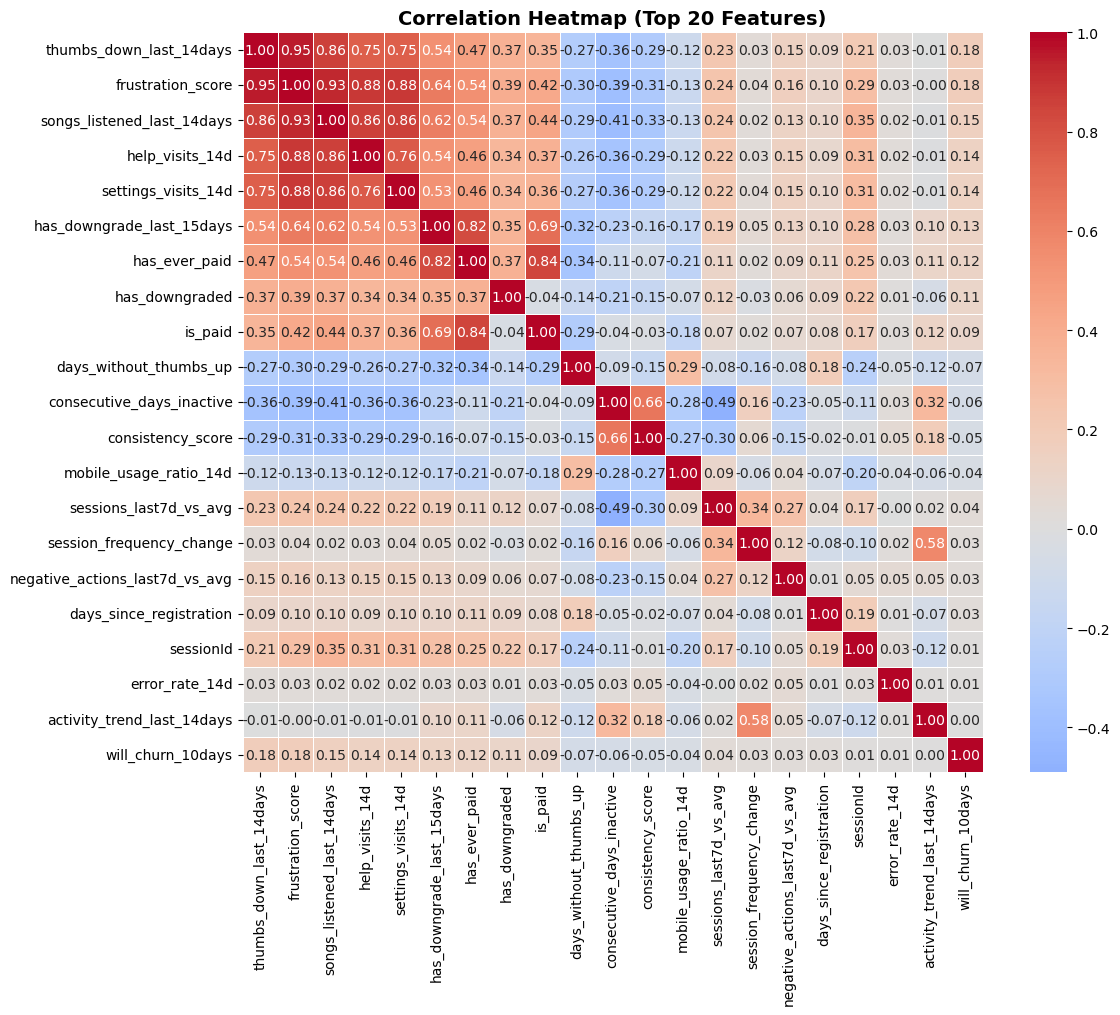

In [ ]:
plot_correlation_heatmap(features)

## Model selection

### Second try with XG Boost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
import numpy as np

def XGB_training(df_features):

    # Prepare data
    feature_cols = [col for col in df_features.columns 
                    if col not in ['userId', 'prediction_date','session_start','session_id', 'session_time','time','registration', 'will_churn_10days']]

    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']

    # Split (NO resampling here!)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Calculate scale_pos_weight: ratio of negative to positive class
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    print(f"Class distribution in train:")
    print(y_train.value_counts())
    print(f"\nCalculated scale_pos_weight: {scale_pos_weight:.2f}")

    # XGBoost with optimal parameters for churn prediction
    model = xgb.XGBClassifier(
        # Handle imbalanced classes
        scale_pos_weight=scale_pos_weight,  # CRITICAL for imbalanced data
        
        # Model complexity
        n_estimators=200,                   # Number of boosting rounds
        max_depth=6,                        # Tree depth (prevent overfitting)
        learning_rate=0.01,                 # Lower = more robust but slower
        
        # Optimization
        objective='binary:logistic',        # Binary classification,                 
        random_state=42,
        n_jobs=-1
    )

    # Train (simplified - no need to pass eval_metric again)
    print("\nTraining XGBoost model...")
    model.fit(
        X_train, y_train,
    )

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    # Feature importance
    import pandas as pd
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 30 Most Important Features:")
    print(feature_importance.head(30).to_string(index=False))
    return X_test, y_test, model


In [ ]:
X_test, y_test, model_XGB = XGB_training(df_consistant)

Class distribution in train:
will_churn_10days
0    105729
1     14926
Name: count, dtype: int64

Calculated scale_pos_weight: 7.08

Training XGBoost model...
balanced accuracy: 0.688547093315523
ROC-AUC: 0.7635

Confusion Matrix:
[[17435  8998]
 [ 1054  2677]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.94      0.66      0.78     26433
       Churn       0.23      0.72      0.35      3731

    accuracy                           0.67     30164
   macro avg       0.59      0.69      0.56     30164
weighted avg       0.85      0.67      0.72     30164


Top 30 Most Important Features:
                       feature  importance
             frustration_score    0.277679
       thumbs_down_last_14days    0.176232
     consecutive_days_inactive    0.107717
                     sessionId    0.076811
                has_downgraded    0.068650
                       is_paid    0.057639
      session_frequency_change    0.034665
        mo

In [ ]:
import numpy as np
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

def find_optimal_threshold(model, X_test, y_test, thresholds=None, plot=True):
    """
    Trouve le seuil qui maximise la Balanced Accuracy
    
    Returns:
    --------
    best_threshold : float
        Optimal threshold
    best_score : float
        Balanced Accuracy at optimal threshold
    results : dict
        All thresholds and their scores
    """
    # Prédictions probabilistes
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Thresholds à tester
    if thresholds is None:
        thresholds = np.arange(0.1, 0.9, 0.01)
    
    # Stocker les résultats
    scores = []
    
    # Tester chaque seuil
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba >= threshold).astype(int)
        ba = balanced_accuracy_score(y_test, y_pred_binary)
        scores.append(ba)
    
    # Trouver le meilleur
    best_idx = np.argmax(scores)
    best_threshold = thresholds[best_idx]
    best_score = scores[best_idx]
    
    # Affichage
    print(f"🎯 Optimal Threshold: {best_threshold:.3f}")
    print(f"📊 Balanced Accuracy: {best_score:.3f}")
    
    # Plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, scores, linewidth=2)
        plt.axvline(best_threshold, color='red', linestyle='--', 
                    label=f'Optimal = {best_threshold:.3f}')
        plt.axhline(best_score, color='red', linestyle='--', alpha=0.3)
        plt.xlabel('Threshold', fontsize=12)
        plt.ylabel('Balanced Accuracy', fontsize=12)
        plt.title('Balanced Accuracy vs Classification Threshold', fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()
    
    # Retourner les résultats
    results = {
        'thresholds': thresholds,
        'scores': scores
    }
    
    return best_threshold, best_score, results

🎯 Optimal Threshold: 0.520
📊 Balanced Accuracy: 0.693


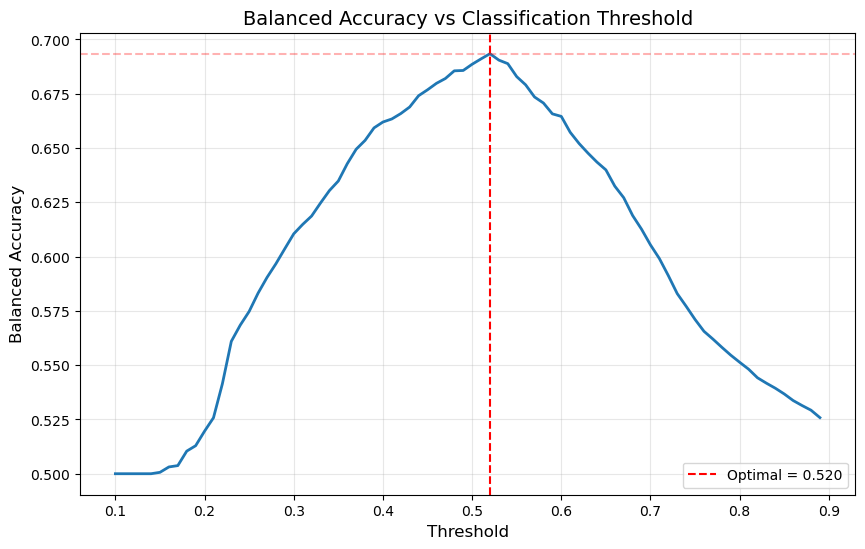

In [ ]:
best_threshold, best_score, results = find_optimal_threshold(model_XGB, X_test, y_test, thresholds=None, plot=True)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
import optuna
import numpy as np
import pandas as pd


def optimize_xgb_with_optuna(df_features, n_trials=100, timeout=3600):
    """
    Optimise les hyperparamètres XGBoost avec Optuna
    
    Args:
        df_features: DataFrame avec features + target
        n_trials: nombre d'essais (défaut: 100)
        timeout: temps max en secondes (défaut: 1h)
        
    Returns:
        best_params, best_model, study
    """
    
    print("="*80)
    print("OPTIMISATION HYPERPARAMÈTRES XGBoost AVEC OPTUNA")
    print("="*80)
    print()
    
    # Préparer les données
    feature_cols = [col for col in df_features.columns 
                    if col not in ['userId', 'prediction_date', 'session_start', 
                                   'session_id', 'session_time', 'time', 
                                   'registration', 'will_churn_10days']]
    
    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']
    
    # Split train/test (test set fixe pour évaluation finale)
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    scale_pos_weight = (y_train_full == 0).sum() / (y_train_full == 1).sum()
    
    print(f"Dataset: {X.shape}")
    print(f"Train: {X_train_full.shape}, Test: {X_test.shape}")
    print(f"Class distribution train: {y_train_full.value_counts().to_dict()}")
    print(f"Scale pos weight: {scale_pos_weight:.2f}")
    print()
    
    # Fonction objectif pour Optuna
    def objective(trial):
        """
        Fonction à optimiser par Optuna
        """
        
        # Suggérer des hyperparamètres
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
            'scale_pos_weight': scale_pos_weight,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_jobs': -1
        }
        
        # Cross-validation stratifiée (3-fold pour vitesse)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        cv_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
            X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
            y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
            
            # Entraîner
            model = xgb.XGBClassifier(**params)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
            
            # Prédire
            y_pred = model.predict(X_val)
            
            # Balanced accuracy
            score = balanced_accuracy_score(y_val, y_pred)
            cv_scores.append(score)
        
        # Moyenne des CV scores
        mean_score = np.mean(cv_scores)
        
        return mean_score
    
    # Créer et lancer l'étude Optuna
    print(f"Lancement de l'optimisation : {n_trials} trials, timeout={timeout}s")
    print()
    
    study = optuna.create_study(
        direction='maximize',  # Maximiser balanced_accuracy
        study_name='xgb_churn_optimization'
    )
    
    study.optimize(
        objective,
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )
    
    # Meilleurs paramètres
    print()
    print("="*80)
    print("RÉSULTATS DE L'OPTIMISATION")
    print("="*80)
    print()
    print(f"Nombre de trials complétés: {len(study.trials)}")
    print(f"Meilleur balanced_accuracy (CV): {study.best_value:.4f}")
    print()
    print("Meilleurs hyperparamètres:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print()
    
    # Entraîner le modèle final avec les meilleurs paramètres
    print("Entraînement du modèle final avec les meilleurs hyperparamètres...")
    
    best_params = study.best_params.copy()
    best_params['scale_pos_weight'] = scale_pos_weight
    best_params['objective'] = 'binary:logistic'
    best_params['random_state'] = 42
    best_params['n_jobs'] = -1
    
    final_model = xgb.XGBClassifier(**best_params)
    final_model.fit(X_train_full, y_train_full)
    
    # Évaluation sur test set
    y_pred = final_model.predict(X_test)
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]
    
    print()
    print("="*80)
    print("PERFORMANCE SUR TEST SET")
    print("="*80)
    print()
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print()
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print()
    print("Top 15 Features:")
    print(feature_importance.head(15).to_string(index=False))
    
    return best_params, final_model, study, X_test, y_test

In [ ]:

# ============================================================================
# UTILISATION
# ============================================================================

if __name__ == "__main__":
    
    # Charger tes données
    df_features = pd.read_csv('features_with_target.csv')
    
    # Optimiser (100 trials = ~30-60 min selon ton dataset)
    best_params, best_model, study, X_test, y_test = optimize_xgb_with_optuna(
        df_features,
        n_trials=100,  # Plus = meilleur mais plus long
        timeout=3600   # 1 heure max
    )
    
    # Sauvegarder le modèle
    import joblib
    joblib.dump(best_model, 'best_xgb_model.pkl')
    print("\n✓ Modèle sauvegardé: best_xgb_model.pkl")
    
    # Visualiser l'optimisation (optionnel)
    try:
        import plotly
        
        # Importance des hyperparamètres
        fig1 = optuna.visualization.plot_param_importances(study)
        fig1.write_html('optuna_param_importance.html')
        
        # Histoire de l'optimisation
        fig2 = optuna.visualization.plot_optimization_history(study)
        fig2.write_html('optuna_history.html')
        
        print("✓ Visualisations sauvegardées: optuna_param_importance.html, optuna_history.html")
    except:
        print("⚠️  Plotly non installé, pas de visualisations")

[I 2025-12-10 19:54:15,069] A new study created in memory with name: xgb_churn_optimization


OPTIMISATION HYPERPARAMÈTRES XGBoost AVEC OPTUNA

Dataset: (175059, 20)
Train: (140047, 20), Test: (35012, 20)
Class distribution train: {0: 125121, 1: 14926}
Scale pos weight: 8.38

Lancement de l'optimisation : 100 trials, timeout=3600s



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-10 19:54:16,826] Trial 0 finished with value: 0.6839465443310399 and parameters: {'n_estimators': 133, 'max_depth': 9, 'learning_rate': 0.00835336570589888, 'min_child_weight': 2, 'subsample': 0.9443995830755636, 'colsample_bytree': 0.9325127416837676, 'gamma': 2.002026810249762, 'reg_alpha': 1.9833099310930065, 'reg_lambda': 0.7626753720280111}. Best is trial 0 with value: 0.6839465443310399.
[I 2025-12-10 19:54:19,337] Trial 1 finished with value: 0.6885155578138588 and parameters: {'n_estimators': 423, 'max_depth': 8, 'learning_rate': 0.2071322852249901, 'min_child_weight': 4, 'subsample': 0.9324701327982112, 'colsample_bytree': 0.5412167231051646, 'gamma': 2.5460259910879506, 'reg_alpha': 2.990588601423889, 'reg_lambda': 4.689424848371847}. Best is trial 1 with value: 0.6885155578138588.
[I 2025-12-10 19:54:21,241] Trial 2 finished with value: 0.6969076645737964 and parameters: {'n_estimators': 174, 'max_depth': 9, 'learning_rate': 0.03856385957586069, 'min_child_weight'

In [ ]:
feature_cols = [col for col in df_features.columns 
                if col not in ['userId', 'prediction_date', 'session_start', 
                                'session_id', 'session_time', 'time', 
                                'registration', 'will_churn_10days']]

X = df_features[feature_cols].fillna(0)
y = df_features['will_churn_10days']

In [ ]:
production_model = xgb.XGBClassifier(**best_params)
production_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9131780083069162, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=4.510410242462292, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02567117579350988,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=457, n_jobs=-1,
              num_parallel_tree=None, ...)

🎯 Optimal Threshold: 0.510
📊 Balanced Accuracy: 0.851


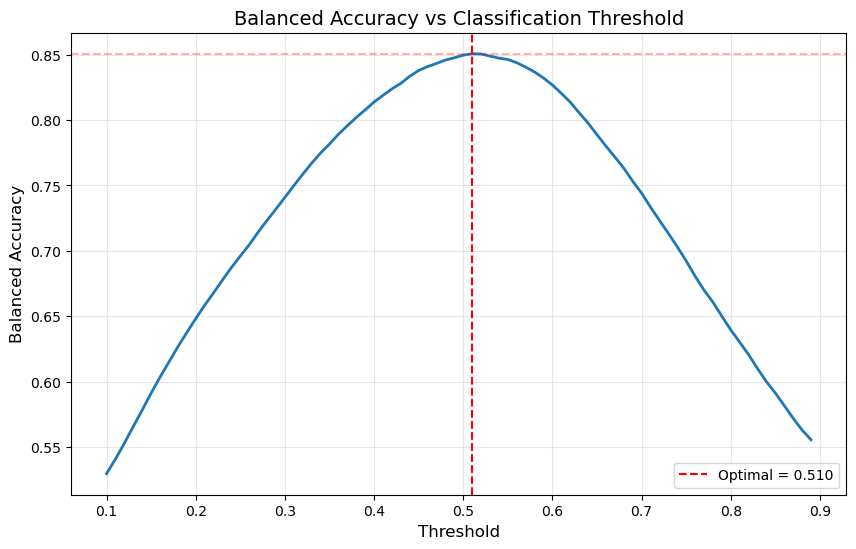

In [ ]:
best_threshold, best_score, results = find_optimal_threshold(production_model, X, y, thresholds=None, plot=True)

In [ ]:
X.shape[0]

175059

In [ ]:
from sklearn.metrics import brier_score_loss

y_pred_proba = production_model.predict_proba(X)[:, 1]
brier = brier_score_loss(y, y_pred_proba)

print(f"Brier Score: {brier:.4f}")  # Plus bas = mieux

Brier Score: 0.1262


In [ ]:
# Calcul baseline
baseline_proba = np.full(len(y), y.mean())
baseline_brier = brier_score_loss(y, baseline_proba)

print(f"Baseline Brier: {baseline_brier:.4f}")
print(f"Model Brier: {brier:.4f}")
print(f"Amélioration: {(baseline_brier - brier) / baseline_brier * 100:.1f}%")

Baseline Brier: 0.0952
Model Brier: 0.1262
Amélioration: -32.6%


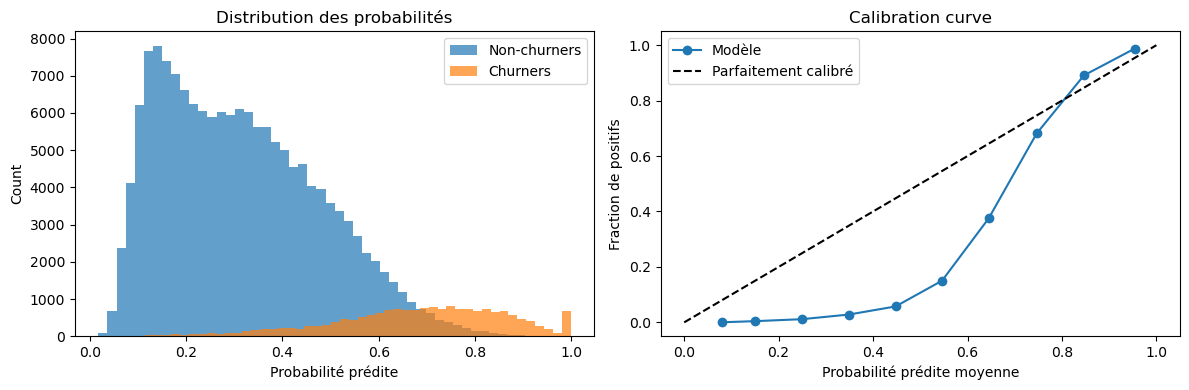

Probas prédites - Mean: 0.3537, Std: 0.2009
Vrai churn rate: 0.1066


In [ ]:
import matplotlib.pyplot as plt

# Distribution des probas prédites
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba[y==0], bins=50, alpha=0.7, label='Non-churners')
plt.hist(y_pred_proba[y==1], bins=50, alpha=0.7, label='Churners')
plt.xlabel('Probabilité prédite')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution des probabilités')

plt.subplot(1, 2, 2)
# Calibration curve
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y, y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
plt.plot([0, 1], [0, 1], 'k--', label='Parfaitement calibré')
plt.xlabel('Probabilité prédite moyenne')
plt.ylabel('Fraction de positifs')
plt.legend()
plt.title('Calibration curve')

plt.tight_layout()
plt.show()

# Stats
print(f"Probas prédites - Mean: {y_pred_proba.mean():.4f}, Std: {y_pred_proba.std():.4f}")
print(f"Vrai churn rate: {y_test.mean():.4f}")

In [ ]:
# Split train/test (test set fixe pour évaluation finale)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score

# 1. Calibrer
print("Calibration en cours...")
calibrated_model = CalibratedClassifierCV(
    production_model, 
    method='isotonic',
    cv='prefit'
)
calibrated_model.fit(X_train, y_train)

# 2. Prédictions SUR LE TEST SET
y_pred_proba = production_model.predict_proba(X_test)[:, 1]  # ← AVANT calibration
y_pred_proba_cal = calibrated_model.predict_proba(X_test)[:, 1]  # ← APRÈS calibration

# 3. Vérifier les tailles
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_pred_proba shape: {y_pred_proba.shape}")
print(f"y_pred_proba_cal shape: {y_pred_proba_cal.shape}")

# 4. Comparer
print("\n" + "="*60)
print("AVANT CALIBRATION:")
print(f"Brier Score: {brier_score_loss(y_test, y_pred_proba):.4f}")
print(f"Mean proba: {y_pred_proba.mean():.4f}")

print("\nAPRÈS CALIBRATION:")
print(f"Brier Score: {brier_score_loss(y_test, y_pred_proba_cal):.4f}")
print(f"Mean proba: {y_pred_proba_cal.mean():.4f}")

print(f"\nVrai churn rate: {y_test.mean():.4f}")
print("="*60)

# 5. ROC-AUC (ne doit pas changer)
print(f"\nROC-AUC avant: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"ROC-AUC après: {roc_auc_score(y_test, y_pred_proba_cal):.4f}")

Calibration en cours...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/calibration.py:333: UserWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



X_test shape: (35012, 20)
y_test shape: (35012,)
y_pred_proba shape: (35012,)
y_pred_proba_cal shape: (35012,)

AVANT CALIBRATION:
Brier Score: 0.1252
Mean proba: 0.3528

APRÈS CALIBRATION:
Brier Score: 0.0503
Mean proba: 0.1054

Vrai churn rate: 0.1066

ROC-AUC avant: 0.9295
ROC-AUC après: 0.9294


In [ ]:
import pandas as pd
import numpy as np

def detect_outliers_iqr(df, features, threshold=3):
    """
    Détecte outliers avec méthode IQR
    threshold=3 → très extrême (recommandé pour ne pas trop enlever)
    """
    
    outlier_mask = pd.Series(False, index=df.index)
    
    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_mask |= outliers
        
        print(f"{col}: {outliers.sum():,} outliers ({outliers.sum()/len(df)*100:.2f}%)")
        print(f"  Range normal: [{lower_bound:.2f}, {upper_bound:.2f}]")
        print(f"  Range réel: [{df[col].min():.2f}, {df[col].max():.2f}]")
        print()
    
    print(f"Total lignes avec au moins 1 outlier: {outlier_mask.sum():,} ({outlier_mask.sum()/len(df)*100:.2f}%)")
    
    return outlier_mask

# Utilisation
numeric_features = [
    'thumbs_down_last_14days',
    'songs_listened_last_14days',
    'frustration_score',
    'consecutive_days_inactive',
    'days_since_registration',
    'sessions_last7d_vs_avg'
]

outliers = detect_outliers_iqr(df_features, numeric_features, threshold=3)

# Enlever les outliers
df_clean = df_features[~outliers]
print(f"Dataset nettoyé: {df_clean.shape}")

thumbs_down_last_14days: 1,552 outliers (0.89%)
  Range normal: [-18.00, 24.00]
  Range réel: [0.00, 60.00]

songs_listened_last_14days: 2,298 outliers (1.31%)
  Range normal: [-1319.00, 1859.00]
  Range réel: [0.00, 3569.00]

frustration_score: 1,205 outliers (0.69%)
  Range normal: [-66.00, 91.50]
  Range réel: [0.00, 169.50]

consecutive_days_inactive: 0 outliers (0.00%)
  Range normal: [-16.00, 26.00]
  Range réel: [0.00, 14.00]

days_since_registration: 1,897 outliers (1.08%)
  Range normal: [-97.00, 197.00]
  Range réel: [0.00, 390.00]

sessions_last7d_vs_avg: 534 outliers (0.31%)
  Range normal: [-0.78, 2.37]
  Range réel: [0.00, 4.11]

Total lignes avec au moins 1 outlier: 5,468 (3.12%)
Dataset nettoyé: (169591, 23)


In [ ]:
from sklearn.ensemble import IsolationForest

def detect_outliers_isolation_forest(df, features, contamination=0.05):
    """
    Isolation Forest : détecte patterns anormaux
    contamination = % d'outliers attendus (5% par défaut)
    """
    
    X = df[features].fillna(0)
    
    iso_forest = IsolationForest(
        contamination=contamination,  # 5% d'outliers
        random_state=42,
        n_estimators=100
    )
    
    outliers = iso_forest.fit_predict(X)
    outlier_mask = outliers == -1  # -1 = outlier, 1 = normal
    
    print(f"Outliers détectés: {outlier_mask.sum():,} ({outlier_mask.sum()/len(df)*100:.2f}%)")
    
    # Analyser les outliers
    print("\nStats outliers vs normaux:")
    for col in features[:5]:  # Top 5 features
        normal = df[~outlier_mask][col].mean()
        outlier = df[outlier_mask][col].mean()
        print(f"{col}: Normal={normal:.2f}, Outlier={outlier:.2f}")
    
    return outlier_mask

outliers_iso = detect_outliers_isolation_forest(
    df_features, 
    numeric_features, 
    contamination=0.05
)

df_clean = df_features[~outliers_iso]

Outliers détectés: 8,753 (5.00%)

Stats outliers vs normaux:
thumbs_down_last_14days: Normal=3.26, Outlier=17.62
songs_listened_last_14days: Normal=298.09, Outlier=1366.07
frustration_score: Normal=13.81, Outlier=64.98
consecutive_days_inactive: Normal=5.71, Outlier=2.97
days_since_registration: Normal=53.37, Outlier=96.30


### Rebalance the classes with a SMOTE function

In [ ]:
# We apply smote only to train sets
def apply_smote(df_features):
    """
    Apply SMOTE to balance classes.
    """
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import train_test_split
    
    # Prepare data
    feature_cols = [col for col in df_features.columns 
                   if col not in ['userId', 'session_start','prediction_date','session_time', 'registration', 'will_churn_10days']]
    
    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"Before SMOTE: {len(y_train)} samples")
    print(f"After SMOTE:  {len(y_train_balanced)} samples")
    print(f"Class 0: {(y_train_balanced==0).sum()}, Class 1: {(y_train_balanced==1).sum()}")
    
    return X_train_balanced, y_train_balanced, X_test, y_test

In [ ]:
X_train_balanced, y_train_balanced, X_test, y_test = apply_smote(df_consistant)

Before SMOTE: 120655 samples
After SMOTE:  211458 samples
Class 0: 105729, Class 1: 105729


In [ ]:
from sklearn.metrics import balanced_accuracy_score
def train_random_forest(X_train, y_train, X_test, y_test):
    """
    Train Random Forest and evaluate.
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, roc_auc_score
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print(f"balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    
    return rf, roc_auc

In [ ]:
model_rf_SMOTE, score = train_random_forest(X_train_balanced, y_train_balanced, X_test, y_test)

balanced accuracy: 0.6842641438421104
ROC-AUC: 0.7902

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.92      0.93      0.93     26433
       Churn       0.47      0.44      0.45      3731

    accuracy                           0.87     30164
   macro avg       0.70      0.68      0.69     30164
weighted avg       0.87      0.87      0.87     30164



🎯 Optimal Threshold: 0.340
📊 Balanced Accuracy: 0.720


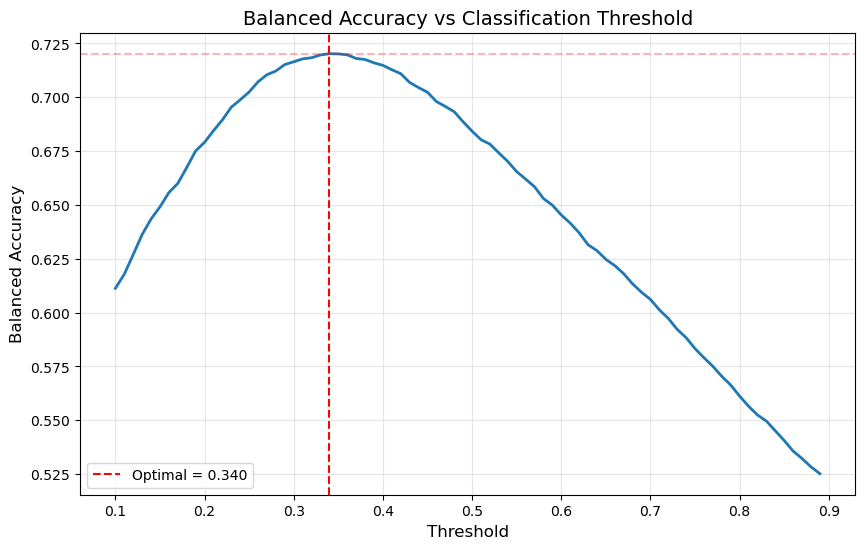

In [ ]:
# Après avoir entraîné ton modèle
best_threshold, best_ba, results = find_optimal_threshold(model_rf_SMOTE, X_test, y_test)

# Prédictions avec le seuil optimal
y_pred_optimal = (model_rf_SMOTE.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

In [ ]:
# Prepare data 
feature_cols = [col for col in df_consistant.columns 
                if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]

X = df_consistant[feature_cols].fillna(0)
y = df_consistant['will_churn_10days']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
model, score = train_random_forest(X_train, y_train, X_test, y_test)

ValueError: could not convert string to float: '2018-11-15'